In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
import zipfile


def load_data(file_name):
    feat = torch.load(file_name)
    return feat

def un_zip(file_name):
    with zipfile.ZipFile(file_name,'r') as zip_file:
        extract_dir = file_name.rsplit('.',1)[0] + "_files" #创建解压后的文件夹
        if not os.path.isdir(extract_dir):
            os.mkdir(extract_dir)
        zip_file.extractall(extract_dir) #将 zip_file 中的所有文件和目录提取到 extract_dir 目录中
        return extract_dir
    
def extract_file():
    current_directory = os.getcwd()
    file_path = None
    for file_name in os.listdir(current_directory):
        if file_name.endswith('.zip'):
            file_path = un_zip(file_name)
            print (f'successfully unzip {file_name}')
    return file_path


def random_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#def concat_feat(x,concat_number):
    
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()    

# Dataset

In [2]:
from torch.utils.data import Dataset

class LibriDataset(Dataset):
    def __init__(self,X,y = None):
        if X.dtype != torch.long:
            X = X.to(torch.long)
        self.data = X  
        if y is None:
            self.label = None
        else:
            if y.dtype != torch.long:
                y = y.to(torch.long)
            self.label = y  

    
    def __getitem__(self,idx):
        if self.label is not None:
            return self.data[idx],self.label[idx]
        else:
            return self.data[idx]
        
    def __len__(self):
        return len(self.data)      

# Model

In [3]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(BasicBlock,self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim,output_dim),
            nn.BatchNorm1d(output_dim), #批量归一化
            nn.ReLU(),
            nn.Dropout(p = 0.15)
        )
    def forward(self,x):
        x = x.float()
        output = self.block(x)
        return output

class Classifier(nn.Module):
    def __init__(self,input_dim,output_dim=41,hidden_layers=1,hidden_dim = 256):
        super(Classifier,self).__init__()
        
        self.fc = nn.Sequential(
            BasicBlock(input_dim,hidden_dim),
            *[BasicBlock(hidden_dim,hidden_dim) for _ in range(hidden_layers-1)],
            nn.Linear(hidden_dim,output_dim)
        )
    def forward(self,x):
        x = x.long()
        output = self.fc(x)
        return output

# unities

In [4]:
import random
def shift(x,dis):
    if dis < 0:
        dis = abs(dis)
        left = x[0,:].repeat(dis,1)
        temp_torch = torch.cat((left,x[:-dis]),dim = 0)
    elif dis > 0:
        right = x[-1,:].repeat(dis,1)
        temp_torch = torch.cat((x[dis:],right),dim = 0)
    else:
        return x
    return temp_torch 

def concat_data(x,number):   #x是一个25*39的tensor,number代表了拼接窗口的总数
    assert number % 2 == 1,"Error!"
    if number < 2: return x
    seq_len , feature_dim = x.size(0),x.size(1)
    x = x.repeat(1,number) #(448 , 39*3)    
    x = x.view(seq_len , number , feature_dim)
    x = x.permute(1,0,2)   #[seq,feature,1]
    mid = number // 2
    for i in range(1,mid + 1):
        x[mid + i,:] = shift(x[mid+i],i) #x[mid+i] (448,39)
        x[mid - i,:] = shift(x[mid-i],-i)  #x[mid-i] (448,39)
    return x.permute(1, 0, 2).view(seq_len, number * feature_dim)


def preprocess_data(split,feat_dir,phone_path,train_ratio=0.8,n_frames = 11,random_seeds = 520):
    class_num = 41 #音素 #feat_dir 是真语音，没有点进去test，phone_path 是 txt的目录
    voice_dict = {}
    mode = 'test' if(split == 'test') else 'train'
    
    if mode == 'train':
        phone_file = open(os.path.join(phone_path,'train_labels.txt'))
        for line in phone_file:
            line = line.strip('\n').split(' ')
            voice_dict[line[0]] = [int(p) for p in line[1:] ]
            #print(f'every voice dict: {voice_dict[line[0]]}')
            
    if mode == 'test':
        phone_file = open(os.path.join(phone_path,'test_split.txt'))
        voice_dict = {}
        for line in phone_file:
            temp = line.strip('\n') 
            voice_dict[temp] = [] #字典的append方式  , 两个字典    
    #print(f'voice_dict is {voice_dict}')
    # 划分数据集和验证集
    if split == 'train' or split == 'val':
            file_to_use = open(os.path.join(phone_path,'train_split.txt')).readlines() #返回的是字典吗
            random.seed(random_seeds)
            random.shuffle(file_to_use) #字典？
            percent = int(len(file_to_use) * train_ratio)
            if split == 'train':
                file_to_use = file_to_use[:percent]
            elif split == 'val':
                file_to_use = file_to_use[percent:]
    elif split == 'test':
        file_to_use = open(os.path.join(phone_path,'test_split.txt')).readlines()
    else :
        raise ValueError('Invalid split in phonedataset')
        
    file_to_use = (line.strip('\n') for line in file_to_use)  
    print('Split finished.')
    
    x = torch.empty(5000000,39*n_frames)
    if mode == 'train':
        y = torch.empty(5000000,dtype=torch.long)   
    idx = 0
    for i,fname in tqdm(enumerate(file_to_use)): 
        feat_dir = 'E:\\pytorch\\ml2023spring-hw2_files\\libriphone\\feat'
        feat = load_data(os.path.join(feat_dir,mode,f'{fname}.pt'))
        #print(f'feat_shape:{feat.shape}') #448是横过去的 ，竖下来是39
        
        feat = concat_data(feat,n_frames)
       # print(f'current feat : {feat} ,{feat.shape}') #448,117
       # print(voice_dict[fname]) 
        current_len = len(feat) 
        if mode != 'test':
            #print(f'Type of voice_dict[fname]: {type(voice_dict[fname])}')
            label = torch.LongTensor(voice_dict[fname])
            y[idx:idx + current_len] = label #不是很理解label。。按道理逻辑上是voice_dict的键，但代码上是值。
        x[idx:idx + current_len,:] = feat # 全部装到x当中    
        idx += current_len
    x = x[:idx,:] # 删去冗余维度
    if mode == 'train':
        y = y[:idx]
        print(f'finish data transform,x size:{x.shape},y size{y.shape}')    
        return x,y
    elif mode == 'test':
        print(f'finish data transform,x size:{x.shape}')
        return x
        

# Hyper-parameters

In [5]:
config = {
    'concat_nframes':5,
    'train_ratio':0.95,
    'num_epoch' : 15,
    'batch_size' : 512,
    'lr':1e-3,
    'model_path':'./model.ckpt',
    'seed': 520,
    'model_path' :'./model.ckpt',
}

input_dim = 39 * config['concat_nframes']
hidden_layers = 6
hidden_dim = 512

# Dataloader

In [6]:
from torch.utils.data import DataLoader,Dataset
import gc

file_path = extract_file()
file_path = file_path + '\\libriphone'
random_seeds(config['seed'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'


train_x,train_y = preprocess_data('train','.\\libriphone\\feat',file_path,config['train_ratio'],config['concat_nframes'],config['seed'])
val_x,val_y = preprocess_data('val','.\\libriphone\\feat',file_path,config['train_ratio'],config['concat_nframes'],config['seed'])

train_set = LibriDataset(train_x,train_y)
val_set = LibriDataset(val_x,val_y)

del train_x,train_y,val_x,val_y
gc.collect()

train_loader =  DataLoader(train_set,batch_size=config['batch_size'],shuffle=True)
val_loader   =  DataLoader(val_set,batch_size=config['batch_size'],shuffle=True)

successfully unzip ml2023spring-hw2.zip
Split finished.


3257it [00:04, 798.32it/s] 


finish data transform,x size:torch.Size([2015332, 195]),y sizetorch.Size([2015332])
Split finished.


172it [00:00, 965.56it/s]

finish data transform,x size:torch.Size([101462, 195]),y sizetorch.Size([101462])


# Training

In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

RESUME = False

model = Classifier(input_dim=input_dim,hidden_layers=hidden_layers,hidden_dim=hidden_dim).to(device)

if RESUME:
    model.load_state_dict(torch.load(config['model_path'],map_location='cuda'))
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.8,patience=5,threshold=0.05)
loss_record = {'train':[],'dev':[]}
train_acc = 0.0
val_acc = 0.0 
best_acc = 0.0

In [9]:
for epoch in range(config['num_epoch']):
    model.train()
    for i , batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        features,labels = batch
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        _,train_pred = torch.max(outputs,1)  #其中第一个元素是最大值的张量，第二个元素是最大值所在位置的张量 
        train_acc += (train_pred.detach() == labels.detach()).sum().item()
        loss_record['train'].append((train_pred.detach() == labels.detach()).sum().item())
    model.eval()
    
    with torch.no_grad():
        for i,batch in enumerate(tqdm(val_loader)):
            features,labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            
            loss = criterion(outputs,labels)
            _, val_pred = torch.max(outputs,1)
            #print(val_pred.shape)
            #print(labels.shape)
            val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
            loss_record['dev'].append((val_pred.cpu() == labels.cpu()).sum().item())
            
    writer.add_scalar('Acc/train',train_acc/len(train_set),epoch)
    writer.add_scalar('Acc/valid',val_acc/len(val_set),epoch)
    writer.add_scalar('lr' , optimizer.state_dict()['param_groups'][0]['lr'],epoch)
    
    print(f'[{epoch +1:03d}/{config["num_epoch"]:03d}] Train Acc:{train_acc/len(train_set):.3f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(),config['model_path'])
        print(f'saving model with acc {best_acc/len(val_set):.5f}')
    print(f'{epoch + 1}, lr:{optimizer.state_dict()["param_groups"][0]["lr"]}')   
    scheduler.step(val_acc/len(val_set))


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 176.13it/s]


[001/015] Train Acc:1.015
saving model with acc 1.07777
1, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 165.02it/s]


[002/015] Train Acc:1.550
saving model with acc 1.63137
2, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 206.50it/s]


[003/015] Train Acc:2.091
saving model with acc 2.18996
3, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 182.92it/s]


[004/015] Train Acc:2.638
saving model with acc 2.74963
4, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 163.24it/s]


[005/015] Train Acc:3.189
saving model with acc 3.31115
5, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 207.37it/s]


[006/015] Train Acc:3.742
saving model with acc 3.87360
6, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 155.30it/s]


[007/015] Train Acc:4.299
saving model with acc 4.43810
7, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 203.31it/s]


[008/015] Train Acc:4.857
saving model with acc 5.00163
8, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 203.72it/s]


[009/015] Train Acc:5.417
saving model with acc 5.56762
9, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 192.99it/s]


[010/015] Train Acc:5.979
saving model with acc 6.13616
10, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 149.09it/s]


[011/015] Train Acc:6.543
saving model with acc 6.70382
11, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 156.85it/s]


[012/015] Train Acc:7.108
saving model with acc 7.27256
12, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 193.98it/s]


[013/015] Train Acc:7.674
saving model with acc 7.84067
13, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 174.00it/s]


[014/015] Train Acc:8.242
saving model with acc 8.40900
14, lr:0.001


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 168.39it/s]

[015/015] Train Acc:8.811
saving model with acc 8.97709
15, lr:0.001


{'train': [7, 83, 107, 124, 135, 140, 151, 171, 159, 160, 171, 180, 185, 181, 193, 184, 199, 197, 209, 186, 208, 212, 176, 198, 218, 188, 209, 195, 187, 224, 219, 207, 199, 205, 183, 213, 215, 195, 193, 235, 200, 221, 203, 195, 183, 207, 196, 203, 211, 212, 223, 210, 201, 208, 208, 190, 210, 216, 214, 208, 206, 231, 201, 231, 216, 208, 225, 219, 211, 230, 206, 213, 193, 209, 196, 230, 194, 218, 205, 192, 217, 234, 222, 227, 223, 213, 214, 216, 225, 209, 224, 231, 209, 238, 231, 206, 203, 213, 234, 211, 219, 220, 213, 224, 208, 223, 226, 221, 219, 222, 211, 251, 222, 234, 231, 234, 237, 218, 212, 205, 220, 205, 213, 213, 234, 221, 250, 226, 227, 222, 230, 211, 213, 224, 227, 220, 230, 241, 248, 217, 239, 237, 209, 197, 231, 224, 211, 223, 220, 224, 230, 222, 234, 253, 219, 229, 232, 205, 216, 228, 236, 227, 235, 240, 218, 243, 205, 227, 225, 222, 208, 234, 237, 242, 229, 224, 219, 230, 237, 216, 227, 235, 239, 222, 234, 236, 243, 234, 218, 225, 242, 241, 212, 247, 244, 223, 228, 229, 23

ValueError: x and y must have same first dimension, but have shapes (3316,) and (3184,)

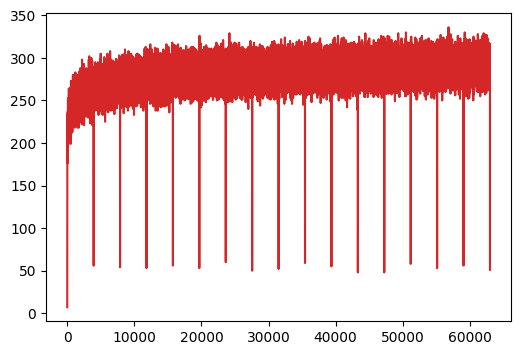

In [10]:
import matplotlib.pyplot as plt
print(loss_record)
plot_learning_curve(loss_record,title = 'train model')
print(f'saving model with acc {best_acc/len(val_set):.5f}')

# Testing

In [11]:
del train_set,val_set
del train_loader,val_loader
gc.collect()

591

In [12]:
test_X = preprocess_data(split='test',feat_dir='.\\libriphone\\feat',phone_path=file_path,train_ratio=0.8,n_frames=config['concat_nframes'],random_seeds=config['seed'])
test_set = LibriDataset(test_X,None)
test_loader = DataLoader(test_set,batch_size=config['batch_size'],shuffle=False)
model = Classifier(input_dim=input_dim,hidden_layers=hidden_layers,hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load(config['model_path']))

Split finished.


857it [00:01, 543.40it/s]


finish data transform,x size:torch.Size([527364, 195])


<All keys matched successfully>

In [13]:
pred = np.array([],dtype = np.int32)
model.eval()
with torch.no_grad():
    for i,batch in enumerate(tqdm(test_loader)):
        features = batch
        features = features.to(device)
        
        outputs = model(features)
        _,test_pred = torch.max(outputs,1)
        pred = np.concatenate((pred,test_pred.cpu().numpy()),axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1031/1031 [00:03<00:00, 261.69it/s]


In [14]:
with open('prediction.csv','w') as f:
    f.write('Id,Class\n')
    for i,y in enumerate(pred):
        f.write('{},{}\n'.format(i,y))